In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
import os
import pandas as pd
import numpy as np
import random
from ultralytics import YOLO
import mediapipe as mp
import torch
import torch.nn.functional as F
import cv2
import pickle
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

---
이미지 증강-3개
최적 파라미터:  lr=0.001, batch_size=16, num_epochs=100, hidden_size=256, num_layers=2

Epoch 1, Train Loss: 0.928536, Validation Loss: 0.769365, Train Accuracy: 50.00%, Validation Accuracy: 48.28%
Epoch 2, Train Loss: 0.796203, Validation Loss: 0.743161, Train Accuracy: 59.91%, Validation Accuracy: 55.17%
Epoch 3, Train Loss: 0.714323, Validation Loss: 0.750985, Train Accuracy: 65.30%, Validation Accuracy: 48.28%
Epoch 4, Train Loss: 0.625480, Validation Loss: 0.759126, Train Accuracy: 66.16%, Validation Accuracy: 58.62%
Epoch 5, Train Loss: 0.608987, Validation Loss: 0.634390, Train Accuracy: 65.52%, Validation Accuracy: 58.62%
Epoch 6, Train Loss: 0.557324, Validation Loss: 0.656435, Train Accuracy: 70.04%, Validation Accuracy: 68.97%
Epoch 7, Train Loss: 0.582431, Validation Loss: 0.715162, Train Accuracy: 73.49%, Validation Accuracy: 72.41%
Epoch 8, Train Loss: 0.485470, Validation Loss: 0.689856, Train Accuracy: 77.59%, Validation Accuracy: 58.62%
Epoch 9, Train Loss: 0.408893, Validation Loss: 0.632355, Train Accuracy: 81.47%, Validation Accuracy: 75.86%
Epoch 10, 

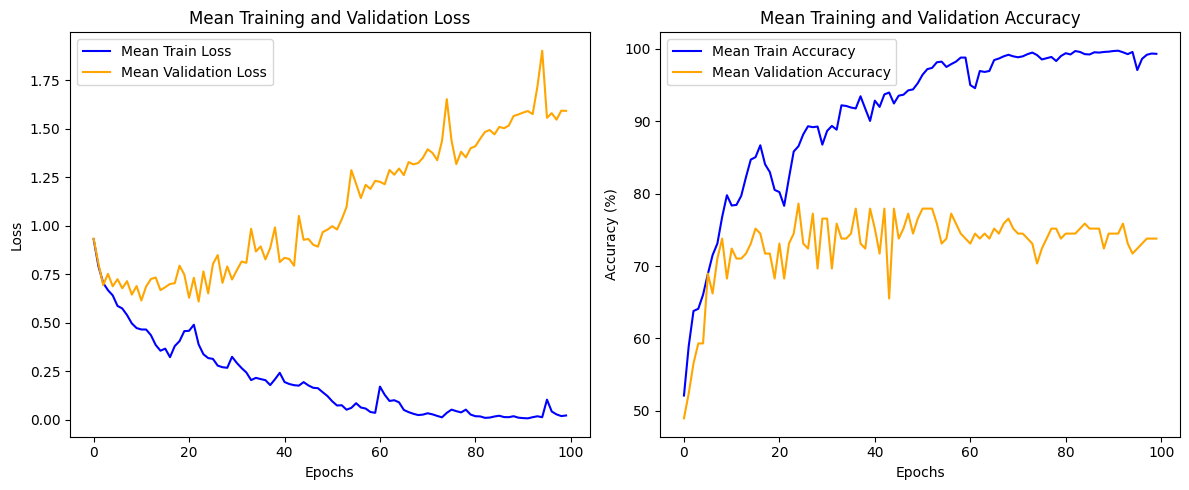

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# 데이터 전처리 함수
def load_and_preprocess_data(data_directory, max_len=100):
    all_data = []
    all_labels = []
    for filename in os.listdir(data_directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_directory, filename)
            df = pd.read_csv(filepath)

            # 파일 이름에서 행동 라벨 추출
            if 'broken' in filename:
                label = 'broken'
            elif 'purchase' in filename:
                label = 'purchase'
            elif 'theft' in filename:
                label = 'theft'
            else:
                continue

            # x, y, z 컬럼 추출
            columns = [f'landmark_{i}_{coord}' for i in range(33) for coord in ['x', 'y', 'z']]
            data = df[columns].values

            # 데이터 패딩 또는 자르기
            if len(data) < max_len:
                padding = np.zeros((max_len - len(data), data.shape[1]))
                data = np.vstack((data, padding))
            elif len(data) > max_len:
                data = data[:max_len]

            all_data.append(data)
            all_labels.append(label)

    return np.array(all_data), np.array(all_labels)

# 데이터 증강 함수
def augment_data(sequences, labels, max_len=100):
    augmented_sequences = []
    augmented_labels = []

    for seq, label in zip(sequences, labels):
        augmented_sequences.append(seq)
        augmented_labels.append(label)

        # 좌우 반전 추가
        flipped_seq = np.copy(seq)
        for i in range(33):
            flipped_seq[:, i*3] = 1 - flipped_seq[:, i*3]       # x 좌표 반전
            flipped_seq[:, i*3 + 2] = -flipped_seq[:, i*3 + 2]  # z 좌표 반전
        augmented_sequences.append(flipped_seq)
        augmented_labels.append(label)

        # 노이즈 추가
        noise_seq = seq + np.random.normal(0, 0.01, seq.shape)
        augmented_sequences.append(noise_seq)
        augmented_labels.append(label)

        # 무작위 시프트
        shift_seq = seq + np.random.uniform(-0.01, 0.01, seq.shape)
        augmented_sequences.append(shift_seq)
        augmented_labels.append(label)

    return np.array(augmented_sequences), np.array(augmented_labels)

# 데이터셋 클래스 정의
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

class SkeletonLSTM(nn.Module):
    def __init__(self, input_size=99, hidden_size=256, num_layers=2, num_classes=3, dropout_prob=0.3):
        super(SkeletonLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        total_train_loss /= len(train_loader)
        train_losses.append(total_train_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # 검증 데이터로 모델 평가
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        total_val_loss /= len(val_loader)
        val_losses.append(total_val_loss)
        val_accuracies.append(100 * correct_val / total_val)

        print(f'Epoch {epoch+1}, Train Loss: {total_train_loss:.6f}, Validation Loss: {total_val_loss:.6f}, '
              f'Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Accuracy: {val_accuracies[-1]:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# 평가 함수
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 시드 설정 함수
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 모든 GPU에 시드 고정
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(50)

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 로드 및 전처리
data_directory = "/content/drive/MyDrive/DL/output_all/mediapipe/processed_csvs"
sequences, seq_labels = load_and_preprocess_data(data_directory)

# 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(seq_labels)

# k-fold 교차 검증 설정
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=50)

best_val_accuracy = 0
best_model = None
fold_accuracies = []
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(sequences)):
    train_sequences, val_sequences = sequences[train_idx], sequences[val_idx]
    train_labels, val_labels = encoded_labels[train_idx], encoded_labels[val_idx]

    # 데이터 증강은 훈련 데이터에만 적용
    train_sequences, train_labels = augment_data(train_sequences, train_labels)

    train_dataset = MyDataset(train_sequences, train_labels)
    val_dataset = MyDataset(val_sequences, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # 모델 초기화
    model = SkeletonLSTM(hidden_size=256, num_layers=2, dropout_prob=0.3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device=device
    )

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    # 검증 데이터로 모델 평가
    val_accuracy = evaluate_model(model, val_loader, device)
    fold_accuracies.append(val_accuracy)
    print(f'Fold {fold+1}, Validation Accuracy: {val_accuracy:.2f}%')

    # 최적 모델 저장
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model

# 전체 fold에 대한 평균 validation accuracy 계산
mean_val_accuracy = np.mean(fold_accuracies)
print(f'Mean Validation Accuracy: {mean_val_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')

# 디렉토리가 없으면 생성
model_dir = '/content/drive/MyDrive/test/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 최적 모델 저장
torch.save(best_model.state_dict(), os.path.join(model_dir, 'best_lstm_behavior_model9.pth'))

# 라벨 인코더 저장
with open(os.path.join(model_dir, 'label_encoder9.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

# 학습 과정 시각화
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_val_losses = np.mean(all_val_losses, axis=0)
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_val_accuracies = np.mean(all_val_accuracies, axis=0)

# Mean Train and Validation Loss 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mean_train_losses, label='Mean Train Loss', color='blue')
plt.plot(mean_val_losses, label='Mean Validation Loss', color='orange')
plt.title('Mean Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Train and Validation Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(mean_train_accuracies, label='Mean Train Accuracy', color='blue')
plt.plot(mean_val_accuracies, label='Mean Validation Accuracy', color='orange')
plt.title('Mean Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy: 80.00%
Classification Report:
              precision    recall  f1-score   support

      broken       0.67      0.83      0.74        12
    purchase       0.92      1.00      0.96        11
       theft       0.88      0.58      0.70        12

    accuracy                           0.80        35
   macro avg       0.82      0.81      0.80        35
weighted avg       0.82      0.80      0.79        35

Confusion Matrix:
[[10  1  1]
 [ 0 11  0]
 [ 5  0  7]]


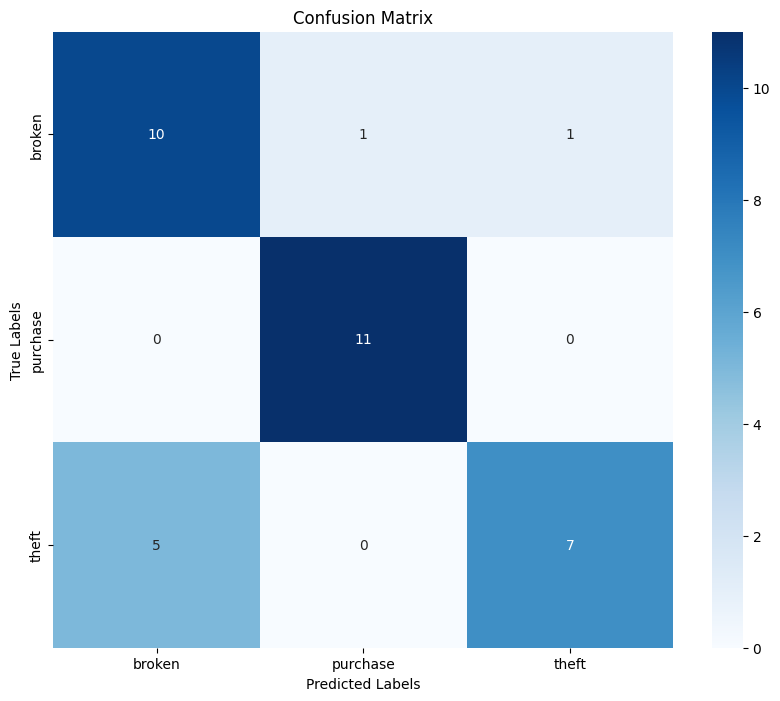

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 로드
best_model = SkeletonLSTM(hidden_size=256, num_layers=2).to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/test/best_lstm_behavior_model9.pth'))
best_model.eval()

# 라벨 인코더 로드
with open('/content/drive/MyDrive/test/label_encoder9.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# 최종 테스트 평가
test_data_directory = "/content/drive/MyDrive/DL/output_all/mediapipe/test_csvs"  # 테스트 데이터 디렉토리 경로 지정
test_sequences, test_labels = load_and_preprocess_data(test_data_directory)
encoded_test_labels = label_encoder.transform(test_labels)
test_data = MyDataset(test_sequences, encoded_test_labels)
test_loader = DataLoader(test_data, batch_size=32)
test_accuracy = evaluate_model(best_model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# 실제값과 예측값 저장 리스트 초기화
all_labels = []
all_predictions = []

# 모델 예측 수행
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = best_model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 실제 라벨과 예측 라벨을 디코딩
all_labels = label_encoder.inverse_transform(all_labels)
all_predictions = label_encoder.inverse_transform(all_predictions)

# classification report 출력
print("Classification Report:")
print(classification_report(all_labels, all_predictions))

# confusion matrix 출력
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix 생성
cm = confusion_matrix(all_labels, all_predictions)
labels = label_encoder.classes_

# Confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()